Data Source:  http://insideairbnb.com/get-the-data.html

## 1. Import Boilerplate code

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import mpl_toolkits
from datetime import datetime
import geopandas

In [2]:
import folium
import mpl_toolkits
import nltk
import textblob

In [3]:
pd.set_option('display.max_columns', None)

## 2. Import Data and review the top 5 fields

In [4]:
data_folder='../../data/airbnb/'
#files: calendar.csv.gz  listings_summary.csv    reviews.csv.gz
# listings.csv     neighbourhoods.csv      reviews_summary.csv
# listings.csv.gz  neighbourhoods.geojson

data_calendar = pd.read_csv(data_folder+"calendar.csv")
data_listings_summary=pd.read_csv(data_folder+"listings_summary.csv")
data_reviews = pd.read_csv(data_folder+"reviews.csv.gz")
data_listings = pd.read_csv(data_folder+"listings.csv",low_memory=False, parse_dates=True)
data_neighbourhoods= pd.read_csv(data_folder+"neighbourhoods.csv", low_memory=False)
data_review_summary=pd.read_csv(data_folder+"reviews_summary.csv")
data_neighbourhoods_geo=pd.read_json(data_folder+"neighbourhoods.geojson")

In [5]:
data_listings.neighborhood_overview.head()

0    Not even 10 minutes by metro from Victoria Sta...
1                                                  NaN
2    Finsbury Park is a friendly melting pot commun...
3    Very easy to get to all the main sites. The tu...
4    A quick guide or a run through about the area ...
Name: neighborhood_overview, dtype: object

## 3. Clean Data
- Remove non-GB based listings
- Remove listings with per day price is greater than £x.00 i.e. any artificial skews in the data
- Remove listings with price, bed etc set as £0
- Remove listings where reviews are in a non-english language

In [6]:
data_listings[data_listings.country_code!="GB"].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
41783,23325697,https://www.airbnb.com/rooms/23325697,20191105115249,2019-11-06,Can torres,M7 minutes to Ibiza Town,NaN,M7 minutes to Ibiza Town,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/b8eef05a-1...,NaN,85507414,https://www.airbnb.com/users/show/85507414,Lionel,2016-07-23,"England, United Kingdom",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/08754...,https://a0.muscache.com/im/pictures/user/08754...,NaN,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Ibiza, Baleares, Spain",LB of Wandsworth,Wandsworth,NaN,Ibiza,Baleares,07814,London,"Ibiza, Spain",ES,Spain,51.47145,-0.14136,f,Villa,Entire home/apt,8,5.5,5.0,6.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Pool,Ki...",NaN,$948.00,NaN,NaN,NaN,NaN,1,$0.00,8,59,8,8,59,59,8.0,59.0,18 months ago,t,23,53,83,173,2019-11-06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,NaN,NaN,t,f,flexible,f,f,1,1,0,0,NaN
57006,30320965,https://www.airbnb.com/rooms/30320965,20191105115249,2019-11-05,"Chambre idéal pour couple, 10min à pied de Camden",Chambre lumineuse très bien situé à 7min à pie...,L’appartement est calme et très bien situé pou...,Chambre lumineuse très bien situé à 7min à pie...,none,Vous trouverez une station de métro (Kentish T...,NaN,NaN,Vous disposerez en plus de la chambre d’une cu...,Je suis disponible par sms ou téléphone dès qu...,Entretenir la chambre et les pièces communes a...,NaN,NaN,https://a0.muscache.com/im/pictures/feb1380b-e...,NaN,63917372,https://www.airbnb.com/users/show/63917372,Fanny,2016-03-21,"Biarritz, Nouvelle-Aquitaine, France",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/54f77...,https://a0.muscache.com/im/pictures/user/54f77...,NaN,1.0,1.0,"['email', 'phone']",t,f,"Londres, France",LB of Camden,Camden,NaN,Londres,NaN,NW5 4RG,London,"Londres, France",FR,France,51.54894,-0.14564,f,Condominium,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,Kitchen,Heating,Washer,""Smoke detector"",...",NaN,$43.00,NaN,NaN,NaN,NaN,1,$0.00,1,30,1,1,30,30,1.0,30.0,10 months ago,t,0,0,0,0,2019-11-05,1,1,2019-01-03,2019-01-03,100.0,10.0,10.0,10.0,10.0,10.0,8.0,t,NaN,"{""translation missing: en.occupancy.taxes.juri...",f,f,flexible,f,f,1,0,1,0,0.1
61178,32394504,https://www.airbnb.com/rooms/32394504,201

In [7]:
data_listings.drop(data_listings[data_listings.country_code!="GB"].index.values,axis=0,inplace=True)

### 3a. Map in numerical price from summary file

In [8]:
data_listings['price2'] = data_listings['id'].map(data_listings_summary.set_index('id')['price'])

In [9]:
data_listings.isnull().sum()[data_listings.isnull().sum()>0]

name                               25
summary                          4331
space                           25848
description                      2384
neighborhood_overview           30372
notes                           52266
transit                         30745
access                          39318
interaction                     35284
house_rules                     35805
thumbnail_url                   85065
medium_url                      85065
xl_picture_url                  85065
host_name                          12
host_since                         12
host_location                     228
host_about                      35748
host_response_time              25897
host_response_rate              25897
host_acceptance_rate            85065
host_is_superhost                  12
host_thumbnail_url                 12
host_picture_url                   12
host_neighbourhood              18743
host_listings_count                12
host_total_listings_count          12
host_has_pro

### 3b. Drop scrape_id,l isting_url,interaction,notes,thumbnail_url,medium_url,picture_url,host_url,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_thumbnail_url,host_picture_url,host_listings_count,host_verifications,host_identity_verified

In [10]:
data_listings.drop(["scrape_id","listing_url","interaction","notes","thumbnail_url","medium_url","picture_url","host_url","host_name","host_response_time","host_response_rate","host_acceptance_rate","host_thumbnail_url","host_picture_url","host_listings_count","host_verifications","host_identity_verified"],axis=1,inplace=True)
data_listings.drop(["first_review","license","jurisdiction_names","requires_license","require_guest_phone_verification"],axis=1,inplace=True)
data_listings.drop(["xl_picture_url","host_location","market","smart_location","country_code","country","is_location_exact"],axis=1,inplace=True)
data_listings.drop(["host_neighbourhood","street","square_feet","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","review_scores_accuracy","review_scores_checkin","review_scores_communication","review_scores_value"],axis=1,inplace=True)
data_listings.drop(["neighbourhood_group_cleansed","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"],axis=1,inplace=True)
data_listings.drop(["transit","zipcode","city","state"],axis=1,inplace=True)
data_listings.drop(['maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights'],axis=1,inplace=True)
data_listings.drop(["bathrooms","bedrooms","neighbourhood",'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',"is_business_travel_ready"],axis=1,inplace=True)
data_listings.drop(["has_availability","extra_people"],axis=1,inplace=True)


In [11]:
data_listings.drop(["number_of_reviews_ltm"],axis=1,inplace=True)

In [12]:
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2'],
      dtype='object')

### 3c. Dropping meaningful variables with null and or 0 values

In [13]:
data_listings.drop(data_listings[data_listings.beds==0].index.values,axis=0, inplace=True)

In [14]:
data_listings.drop(data_listings[data_listings.beds.isnull()].index.values,axis=0, inplace=True)

In [15]:
#data_listings.drop(data_listings[data_listings.neighbourhood.isnull()].index.values,axis=0, inplace=True)

In [16]:
data_listings.drop(data_listings[data_listings.review_scores_rating.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_cleanliness.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_location.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_is_superhost.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_has_profile_pic.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.property_type=="Parking Space"].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.price2==10000].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2>250].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2==0].index.values,inplace=True)

In [17]:
data_listings.drop(data_listings[data_listings.reviews_per_month.isnull()].index.values,axis=0, inplace=True)

### 3d. Identify the numerical, categorical and qualitative variables

In [18]:
#numeric_fields

In [19]:
# data_listings.dtypes[data_listings.dtypes!=object].index.values
# text_fields=data_listings.dtypes[data_listings.dtypes==object].index.values
# numeric_fields=data_listings.dtypes[data_listings.dtypes!=object].index.values
# np.delete(numeric_fields,[0,2],)
# data_listings[numeric_fields].describe()
# ar=np.argwhere(numeric_fields == ("price2"))
# car=np.argwhere(numeric_fields == ("price_per_guest"))
# bar=np.argwhere(numeric_fields == ("pppg_prop"))
# dar=np.argwhere(numeric_fields == ("latitude"))
# var=np.argwhere(numeric_fields == ("longitude"))
# gar=np.argwhere(numeric_fields == ("id"))
# far=np.argwhere(numeric_fields == ("host_id"))
# xar=np.argwhere(numeric_fields == ("host_is_superhost"))
# yar=np.argwhere(numeric_fields == ("host_has_profile_pic"))
# zar=np.argwhere(numeric_fields == ("require_guest_profile_picture"))
# ear=np.argwhere(numeric_fields == ("dist_lat"))
# iar=np.argwhere(numeric_fields == ("dist_long"))

# numeric_fields=np.delete(numeric_fields,[ar,bar,car,var,dar,gar,far,xar,yar,zar,ear,iar])

### 3e. Introduce price per guest variable

In [20]:
data_listings['price_per_guest']=data_listings['price2']/data_listings['accommodates']

In [21]:
data_listings.price_per_guest.max()

250.0

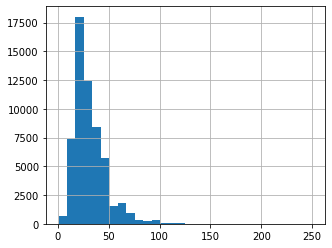

In [22]:
data_listings.price_per_guest.hist(bins=30,figsize=(5,4))

In [23]:
## Let's check for skew and kurtosis
print("Skewness before log transform: ", data_listings.price_per_guest.skew())
print("Kurtosis before log transform: ",data_listings.price_per_guest.kurt())


Skewness before log transform:  2.2195241380417405
Kurtosis before log transform:  11.116117148856201


Skewness before log transform:  -0.0488371620279598
Kurtosis before log transform:  1.0926223081728863


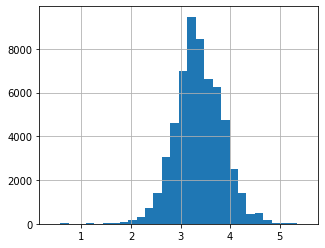

In [24]:
#One can argue this is too much kurtosis though a fairly acceptable level of skew. Let's try and take an exponential attempt and an attempt with normalising y.
Y = np.log1p(data_listings.price_per_guest)
print("Skewness before log transform: ", Y.skew())
print("Kurtosis before log transform: ",Y.kurt())
#Let's visulaise the histogram
Y.hist(bins=30,figsize=(5,4));

In [25]:
#Let's normalise our Y
data_listings.price_per_guest = np.log1p(data_listings.price_per_guest)


### 3f. Factorize boolean variables and identify categorical variables

In [26]:
#data_listings.host_is_superhost.head()

In [27]:
# codes,uniques=data_listings.host_is_superhost.factorize()
# data_listings.host_is_superhost=codes
# data_listings.plot.scatter("host_is_superhost","price2");

In [28]:
#data_listings.host_is_superhost.head()

In [29]:
#data_listings.host_has_profile_pic.head()

In [30]:
# codes,uniques=data_listings.host_has_profile_pic.factorize()
# data_listings.host_has_profile_pic=codes
#data_listings.plot.scatter("number_of_reviews","price2")

In [31]:
# codes,uniques=data_listings.require_guest_profile_picture.factorize()
# data_listings.require_guest_profile_picture=codes
# data_listings.plot.scatter("require_guest_profile_picture","price2");


In [32]:
# codes,uniques=data_listings.instant_bookable.factorize()
# data_listings.instant_bookable=codes
# data_listings.plot.scatter("instant_bookable","price2")

### 3g. Visualise relationships between numerical variables to ensure no unnecessary variables are retained

In [37]:
#from the above, we can see little relation between minimum_nights and host_total_listings_count and we can delete them
data_listings.drop(["minimum_nights","host_total_listings_count"],axis=1,inplace=True)

### 3e. Transform neighbourhood and geographical attributes 
#### The latitude and longitude variables reflect a "quadratic relation with price per guest". This in line with our expectation of central London house prices. We will explore this relationship visually and apply a transformation to make it consummable in linear regression.

In [38]:
#zonation data
Zone1=["City of London", "Camden", "Hackney", "Islington", "Kensington and Chelsea", "Southwark", "Westminster"]
Zone2=["Greenwich", "Hackney", "Hammersmith and Fulham", "Lewisham", "Tower Hamlets", "Wandsworth","Lambeth"]
Zone3=["Barnet", "Brent", "Bromley", "Croydon", "Ealing","Hounslow", "Newham", "Richmond upon Thames", "Waltham Forest"]
Zone4=["Barking and Dagenham", "Bexley","Enfield", "Haringey","Merton", "Newham", "Redbridge", "Sutton","Kingston upon Thames"]
Zone5=["Harrow", "Hillingdon","Havering"]


In [39]:
#count=1
zones= [Zone1,Zone2,Zone3,Zone4,Zone5]
mapping=dict()
for bo in data_listings.neighbourhood_cleansed.unique():
    if bo in (Zone1 + Zone2 + Zone3 + Zone4 + Zone5):
        for count,zns in enumerate(zones):
            if bo in zns:
                mapping[bo]="Zone" + str(count+1)
    else:
        print(bo)
            
            

In [40]:
mapping
def zonify(neighbourhood_cleansed):
    return(mapping.get(neighbourhood_cleansed))

In [41]:
data_listings["Fare_Zone_Rough"]=data_listings['neighbourhood_cleansed'].apply(zonify)

### Fit a linear model recursively. Then dummify the categorical variables


In [56]:
#Let's dummify some categories e.g Property Type and Rough Fare Zone
data_listings.columns

Index(['id', 'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'access', 'house_rules',
       'host_id', 'host_since', 'host_about', 'host_is_superhost',
       'host_has_profile_pic', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'beds',
       'bed_type', 'amenities', 'price', 'number_of_reviews', 'last_review',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'reviews_per_month', 'price2',
       'price_per_guest', 'Fare_Zone_Rough', 'pppg_prop'],
      dtype='object')

In [57]:
cates=data_listings[['Fare_Zone_Rough','property_type','cancellation_policy']]

In [58]:
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates, drop_first=True)], axis=1)

In [59]:
cates2=data_listings['bed_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates2, drop_first=True)], axis=1)

In [60]:
cates3=data_listings['room_type']
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates3, drop_first=True)], axis=1)

In [61]:
for field in ['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']:
    data_listings[field]=data_listings[field].map({'t':(field +' true'),'f':(field +' false')})

In [62]:
data_listings[['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']]
cates1=['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']
data_listings=pd.concat([data_listings,pd.get_dummies(data=data_listings[cates1], drop_first=True)], axis=1)
data_listings.head()

,id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,access,house_rules,host_id,host_since,host_about,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,beds,bed_type,amenities,price,number_of_reviews,last_review,review_scores_rating,review_scores_cleanliness,review_scores_location,instant_bookable,cancellation_policy,require_guest_profile_picture,reviews_per_month,price2,price_per_guest,Fare_Zone_Rough,pppg_prop,Fare_Zone_Rough_Zone2,Fare_Zone_Rough_Zone3,Fare_Zone_Rough_Zone4,Fare_Zone_Rough_Zone5,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),property_type_Chalet,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Farm stay,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Houseboat,property_type_Hut,property_type_Island,property_type_Lighthouse,property_type_Loft,property_type_Minsu (Taiwan),property_type_Nature lodge,property_type_Other,property_type_Ryokan (Japan),property_type_Serviced apartment,property_type_Tent,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,property_type_Yurt,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,Couch,Futon,Pull-out Sofa,Real Bed,Hotel room,Private room,Shared room,require_guest_profile_picture_require_guest_profile_picture true,instant_bookable_instant_bookable true,host_is_superhost_host_is_superhost true,host_has_profile_pic_host_has_profile_pic true
0,11551,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,Guest will have access to the entire apartment,No Smoking (very strict) No pets are allowed i...,43039,2009-10-03,"Hello, I'm a friendly Italian man with a very ...",host_is_superhost true,host_has_profile_pic true,Lambeth,51.46225,-0.11732,Apartment,Entire home/apt,4,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",$88.00,185,2019-09-15,92.0,9.0,9.0,instant_bookable true,strict_14_with_grace_period,require_guest_profile_picture false,1.58,88,3.135494,Zone2,0.567464,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1
3,38407,2019-11-06,Canary Wharf Immaculate Apt for 2,"The bright, light and stylish apartment in Can...","An entire bright, light and stylish apartment....","The bright, light and stylish apartment in Can...",none,Very easy to get to all the main sites. The tu...,This is a quiet self-contained apartment with ...,Respect both check-in and check-out times.,164566,2010-07-12,"A entire bright, light and stylish apartment. ...",host_is_superhost false,host_has_profile_pic true,Tower Hamlets,51.49995,-0.02624,Apartment,Entire home/apt,2,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",$79.00,137,2017-04-21,95.0,10.0,9.0,instant_bookable true,strict_14_with_grace_period,require_guest_profile_picture false,1.23,79,3.701302,Zone2,0.669864,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1
4,90700,2019-11-06,Sunny Notting Hill flat & terrace,This is a home not a hotel - for the cost gues...,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,A quick guide or a run through about the area ...,The whole place is for our guests to enjoy.,Full rules will be provided on arrival but the...,491286,2011-04-07,I am a cu

In [63]:
pd.set_option('display.max_columns', None)

In [64]:
data_listings.drop(['Fare_Zone_Rough','property_type','cancellation_policy'],axis=1,inplace=True)

In [65]:
data_listings.drop(['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic'],axis=1,inplace=True)

In [66]:
data_listings.dropna(inplace=True)

In [84]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Minsu (Taiwan)',
       'property_type_Nature lodge', 'property_type_Other',
       'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true','Couch', 'Futon',
       'Pull-out Sofa', 'Real Bed','Hotel room', 'Private room',
       'Shared room']]

In [85]:
#split the data into simple train_test_split
Y=data_listings.price_per_guest
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

In [135]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)

In [136]:
kmeans.fit_predict(X_train)

array([3, 3, 0, ..., 0, 0, 0])

In [137]:
print(kmeans.labels_)

[3 3 0 ... 0 0 0]


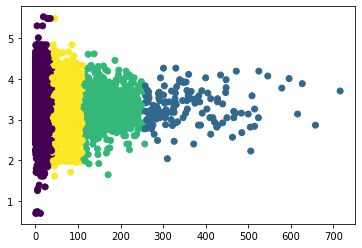

In [138]:
mpl.pyplot.scatter(X_train['number_of_reviews'], Y_train, c=kmeans.labels_);
#mpl.pyplot.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');
mpl.pyplot.show()

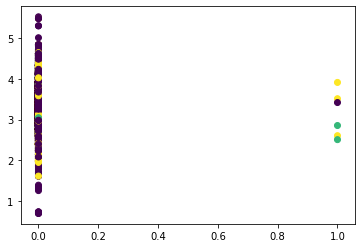

In [139]:
mpl.pyplot.scatter(X_train['property_type_Cabin'], Y_train, c=kmeans.labels_);
#mpl.pyplot.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');
mpl.pyplot.show()

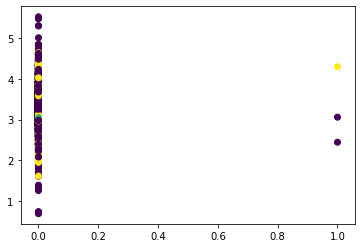

In [140]:
mpl.pyplot.scatter(X_train['property_type_Chalet'], Y_train, c=kmeans.labels_);
#mpl.pyplot.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red');
mpl.pyplot.show()

In [141]:
from sklearn import metrics
metrics.silhouette_score(X_train, kmeans.labels_, metric='euclidean')

0.6118331435410062

In [142]:
kmeans.inertia_

5446260.788255421

In [131]:
inertias = []
ss = []

for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)
    ss.append(metrics.silhouette_score(X_train, kmeans.labels_, metric='euclidean'))

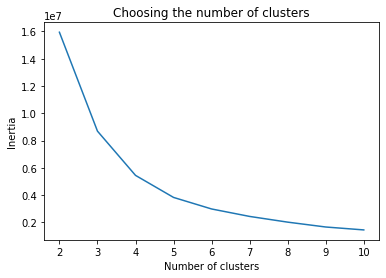

In [133]:
mpl.pyplot.plot(range(2, 11), inertias)
mpl.pyplot.title('Choosing the number of clusters')
mpl.pyplot.xlabel('Number of clusters')
mpl.pyplot.ylabel('Inertia')
mpl.pyplot.show()

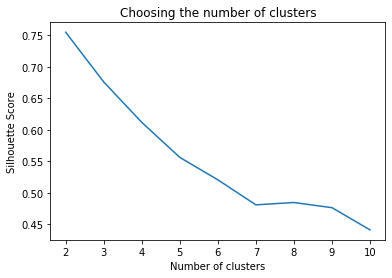

In [134]:
mpl.pyplot.plot(range(2, 11), ss)
mpl.pyplot.title('Choosing the number of clusters')
mpl.pyplot.xlabel('Number of clusters')
mpl.pyplot.ylabel('Silhouette Score')
mpl.pyplot.show()

In [143]:
#Let's trade off between inertia and silhoute score
# add this to entire dataset
kmeans.fit_predict(X)

array([3, 3, 2, ..., 1, 1, 1])

In [144]:
data_listings['clustered']=kmeans.labels_
data_listings.clustered

0        3
3        3
4        2
5        0
6        3
        ..
83382    1
83797    1
83803    1
83816    1
83968    1
Name: clustered, Length: 16141, dtype: int32

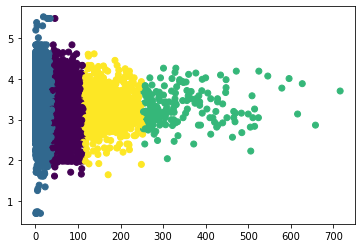

In [147]:
mpl.pyplot.scatter(data_listings.number_of_reviews,data_listings.price_per_guest,c=data_listings.clustered)

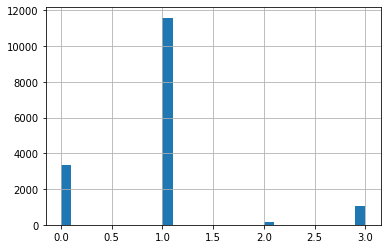

In [154]:
data_listings.clustered.hist(bins=30)

C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


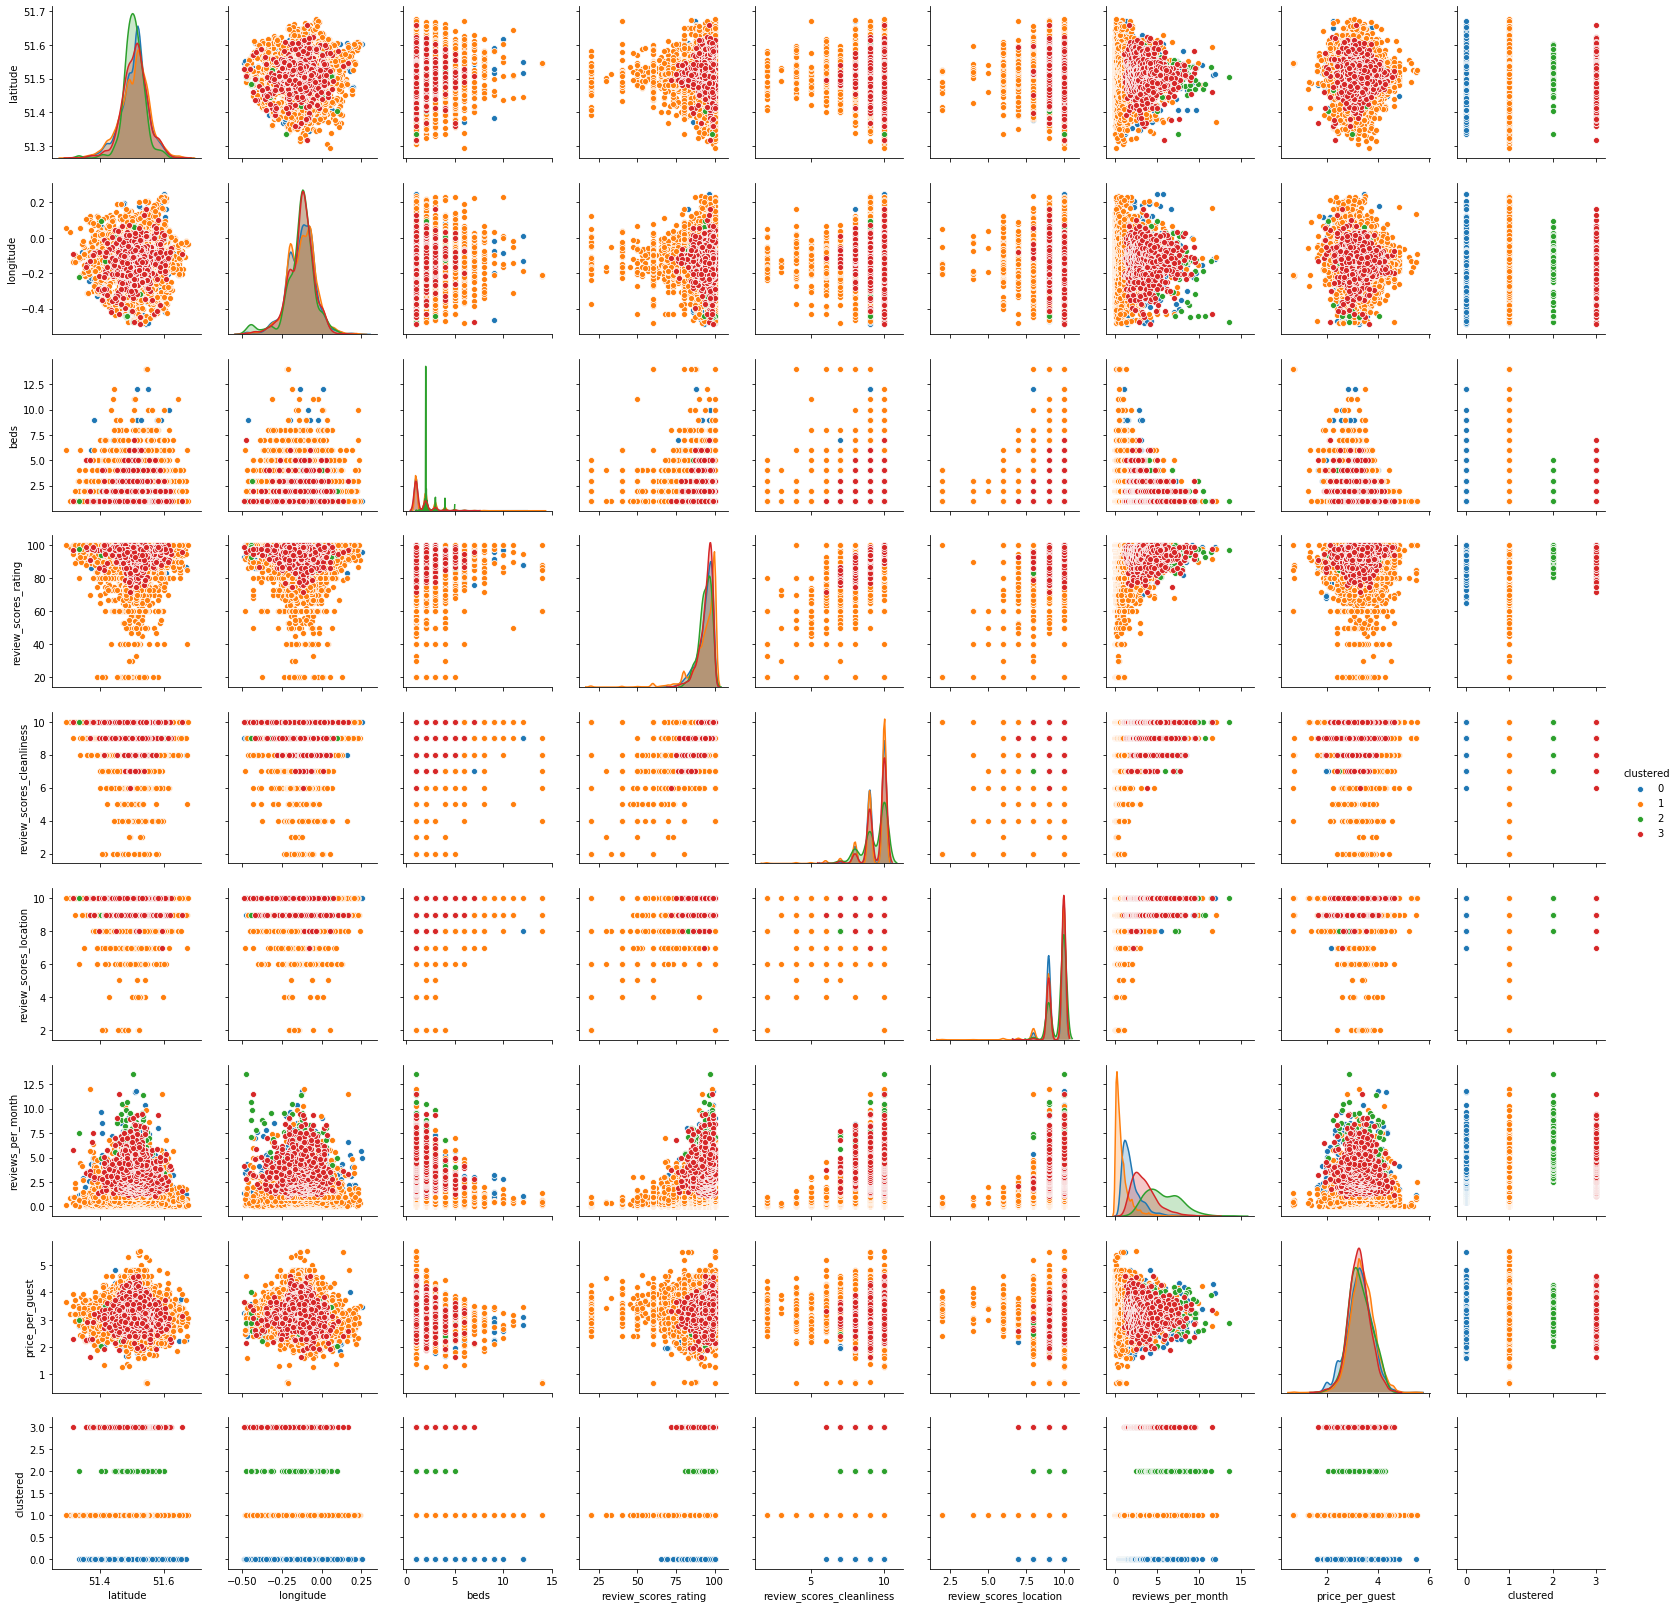

In [163]:
sns.pairplot(data_listings[['neighbourhood_cleansed', 'latitude', 'longitude',
       'room_type', 'beds', 'bed_type', 'amenities', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month',
       'price_per_guest','clustered']], hue='clustered')

In [166]:
# cool - this is great, introduce the remaining regression items or try randomforest regression
#try regression, and then randomtrees
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Camper/RV',
       'property_type_Hostel','instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true','Hotel room', 'Private room',
       'Shared room','clustered']]



In [167]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

In [169]:
from sklearn.linear_model import ElasticNetCV

In [170]:
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(X_train, Y_train)
ElasticNetCV(cv=5, random_state=0)
print(regr.alpha_)
print(regr.coef_)

0.004335544176936268
[-1.41199252e-01 -1.73633541e-04 -3.22864225e-03  4.37898055e-02
  1.08955230e-01 -2.97115461e-02 -1.43190459e-01 -1.56312174e-01
 -6.03708327e-02 -0.00000000e+00 -0.00000000e+00 -2.64901661e-02
  5.31490890e-02  1.13936976e-02 -3.09070328e-01 -2.35887081e-02
  2.61822924e-02]


In [171]:
from sklearn.linear_model import LinearRegression
linreg_fa=LinearRegression()
linreg_fa.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [173]:
price_pred=linreg_fa.predict(X_train)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_train, price_pred)
rmse = np.sqrt(mse)

print('Mean squared error: %f'% mse)
print('Root mean squared error: %f'% rmse)
from sklearn.metrics import r2_score
print("Testing set RMSE: {:.2f}".format(np.sqrt(mean_squared_error(Y_test, linreg_fa.predict(X_test)))))
print("Training set RSquared: {:.2f}".format(r2_score(Y_train, price_pred)))
print("Testing set RSquared: {:.2f}".format(r2_score(Y_test, linreg_fa.predict(X_test))))


Mean squared error: 0.160388
Root mean squared error: 0.400485
Testing set RMSE: 0.40
Training set RSquared: 0.27
Testing set RSquared: 0.26


In [175]:
#try randomforest and decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
treereg= DecisionTreeRegressor(random_state=43)

In [176]:
scores = cross_val_score(treereg,X_train,Y_train,cv=14,scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.5460316008873013

In [177]:
X_train

,beds,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_location,reviews_per_month,Fare_Zone_Rough_Zone3,Fare_Zone_Rough_Zone4,Fare_Zone_Rough_Zone5,property_type_Camper/RV,property_type_Hostel,instant_bookable_instant_bookable true,host_is_superhost_host_is_superhost true,Hotel room,Private room,Shared room,clustered
32418,1.0,59,98.0,10.0,10.0,2.12,0,0,0,0,0,1,1,0,0,0,0
20951,3.0,81,93.0,9.0,10.0,2.05,0,0,0,0,0,0,0,0,0,0,0
24072,2.0,14,94.0,10.0,10.0,0.40,0,0,0,0,0,1,0,0,1,0,1
47668,1.0,5,96.0,8.0,10.0,0.30,0,0,0,0,0,1,0,0,1,0,1
32218,3.0,4,100.0,9.0,10.0,0.18,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43059,2.0,9,96.0,10.0,10.0,0.49,0,0,0,0,0,1,0,1,0,0,1
64140,4.0,19,99.0,10.0,9.0,3.80,0,1,0,0,0,1,0,0,0,0,1
62983,5.0,38,97.0,9.0,9.0,5.73,0,1,0,0,0,1,0,0,1,0,1
64696,2.0,12,62.0,7.0,10.0,1.86,0,0,0,0,0,1,0,0,0,0,1


In [178]:
max_depth_range = list(range(1,20))
RMSE_scores= []

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X_train, Y_train, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))


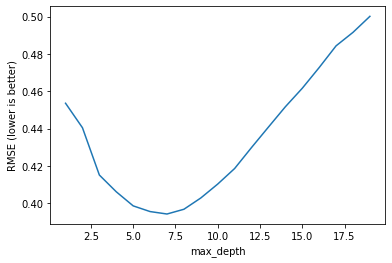

In [179]:
mpl.pyplot.plot(max_depth_range, RMSE_scores);
mpl.pyplot.xlabel('max_depth');
mpl.pyplot.ylabel('RMSE (lower is better)');

In [180]:
np.argmin(RMSE_scores)

6

In [181]:
treereg = DecisionTreeRegressor(max_depth=6, random_state=1)
treereg.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [182]:
feature_importance =pd.DataFrame({'feature':X_train, 'importance':treereg.feature_importances_}).sort_values(by='importance',ascending=False)

In [183]:
feature_importance[feature_importance.importance>0]

,feature,importance
0,"(b, e, d, s)",0.418741
4,"(r, e, v, i, e, w, _, s, c, o, r, e, s, _, l, ...",0.197725
14,"(P, r, i, v, a, t, e, , r, o, o, m)",0.168904
5,"(r, e, v, i, e, w, s, _, p, e, r, _, m, o, n, ...",0.052113
2,"(r, e, v, i, e, w, _, s, c, o, r, e, s, _, r, ...",0.035682
6,"(F, a, r, e, _, Z, o, n, e, _, R, o, u, g, h, ...",0.032139
7,"(F, a, r, e, _, Z, o, n, e, _, R, o, u, g, h, ...",0.028357
1,"(n, u, m, b, e, r, _, o, f, _, r, e, v, i, e, ...",0.020297
15,"(S, h, a, r, e, d, , r, o, o, m)",0.014514
16,"(c, l, u, s, t, e, r, e, d)",0.013949


C:\Users\isimr\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


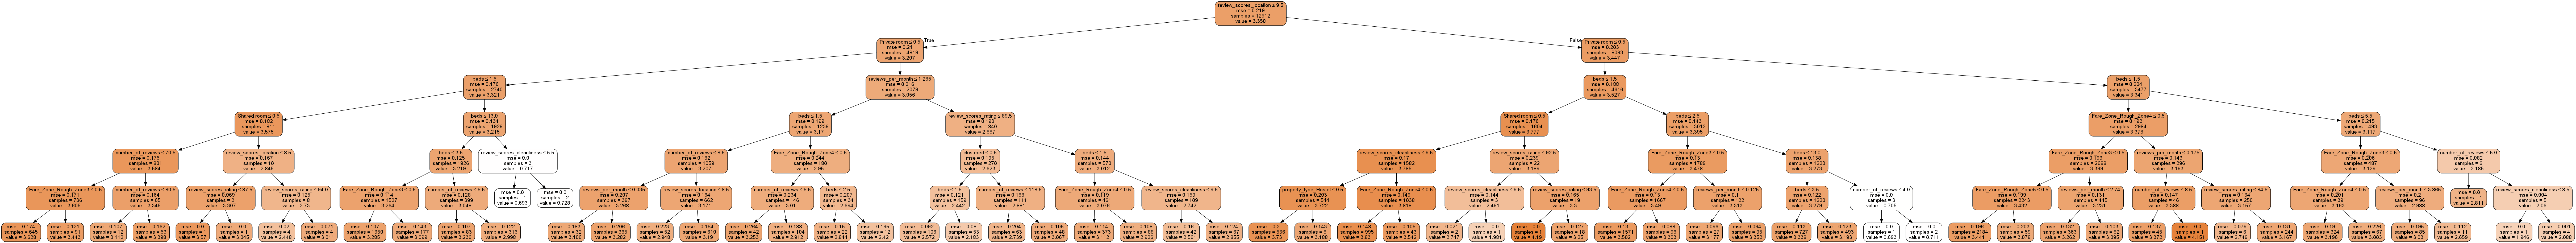

In [184]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image  
dot_data = StringIO()
export_graphviz(treereg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('vehicle_tree.png')
Image(graph.create_png())


In [185]:
from sklearn.metrics import mean_squared_error
Y_pred=treereg.predict(X_test)
np.sqrt(mean_squared_error(Y_test, Y_pred))

0.38872504429482874

In [186]:
from sklearn.metrics import r2_score
print ('R2: ', r2_score(Y_test,Y_pred))

R2:  0.2904985521189136


In [192]:
from sklearn.ensemble import RandomForestRegressor

In [222]:
rfreg = RandomForestRegressor(n_estimators=150, max_features=6, oob_score=True, random_state=1)
rfreg.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=True, random_state=1, verbose=0,
                      warm_start=False)

In [223]:
pd.DataFrame({'feature':X_train.columns, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
9,property_type_Camper/RV,0.000318
10,property_type_Hostel,0.001884
13,Hotel room,0.006207
8,Fare_Zone_Rough_Zone5,0.007865
15,Shared room,0.008755
16,clustered,0.016727
12,host_is_superhost_host_is_superhost true,0.019057
7,Fare_Zone_Rough_Zone4,0.022918
6,Fare_Zone_Rough_Zone3,0.023568
11,instant_bookable_instant_bookable true,0.027055


In [224]:
print((rfreg.oob_score_))

# Find the average RMSE.
scores = cross_val_score(rfreg, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.25434795089998985


0.4016652694777677

In [261]:
from sklearn.metrics import r2_score
print ('R2: ', r2_score(Y_test,rfreg.predict(X_test)))

R2:  0.27909045014554146


In [207]:
feature_range = list(range(1, len(X.columns)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1)
    MSE_scores = cross_val_score(rfreg, X_train, Y_train, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

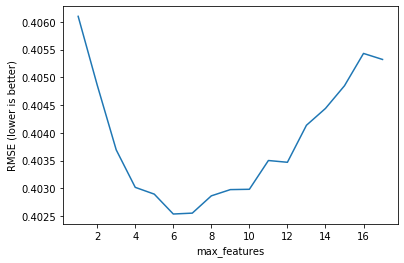

In [208]:
mpl.pyplot.plot(feature_range, RMSE_scores);

mpl.pyplot.xlabel('max_features');
mpl.pyplot.ylabel('RMSE (lower is better)');

In [209]:
sorted(zip(RMSE_scores, feature_range))[0]

(0.4025400450400273, 6)

In [231]:
X.columns

Index(['beds', 'number_of_reviews', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_location',
       'reviews_per_month', 'Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Camper/RV',
       'property_type_Hostel', 'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true', 'Hotel room',
       'Private room', 'Shared room', 'clustered'],
      dtype='object')

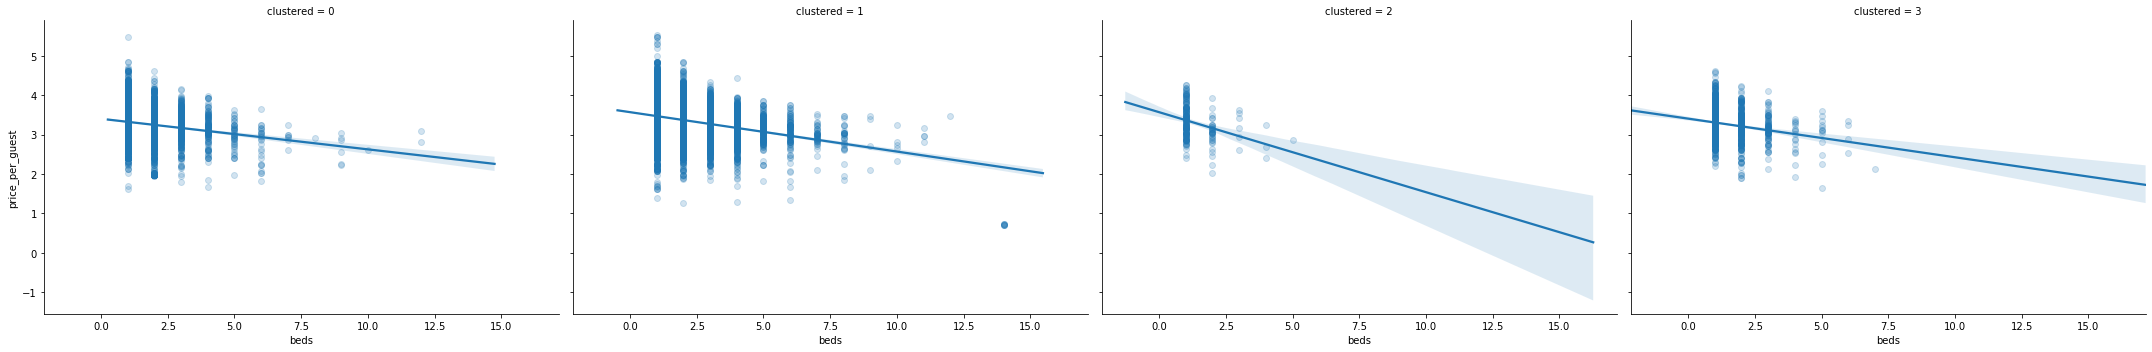

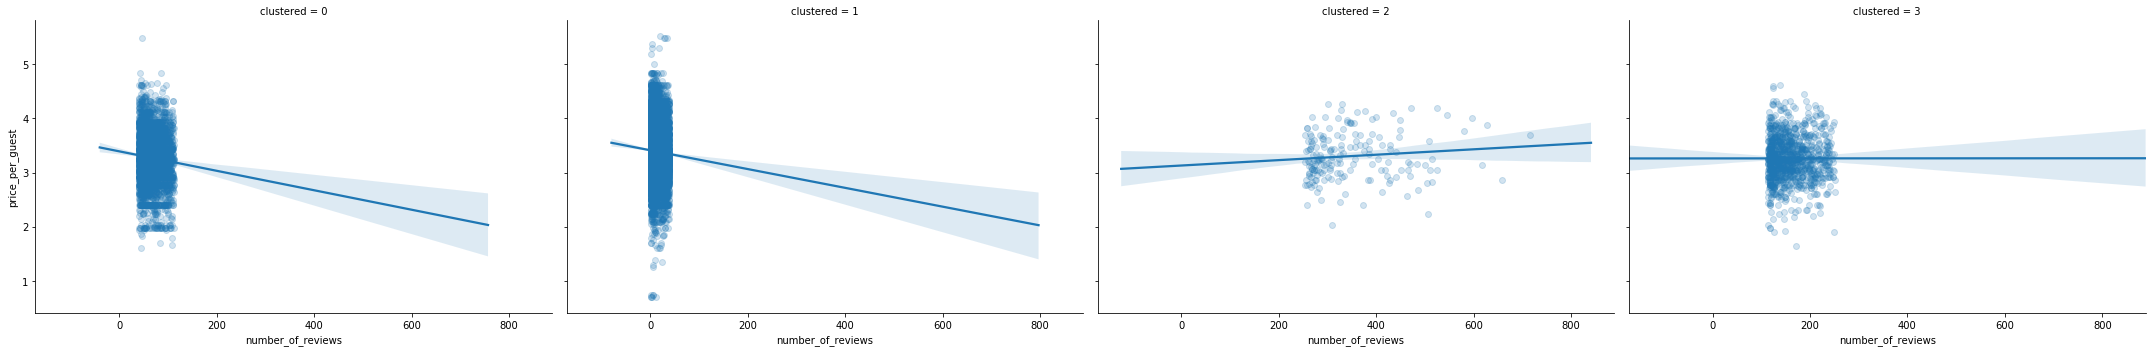

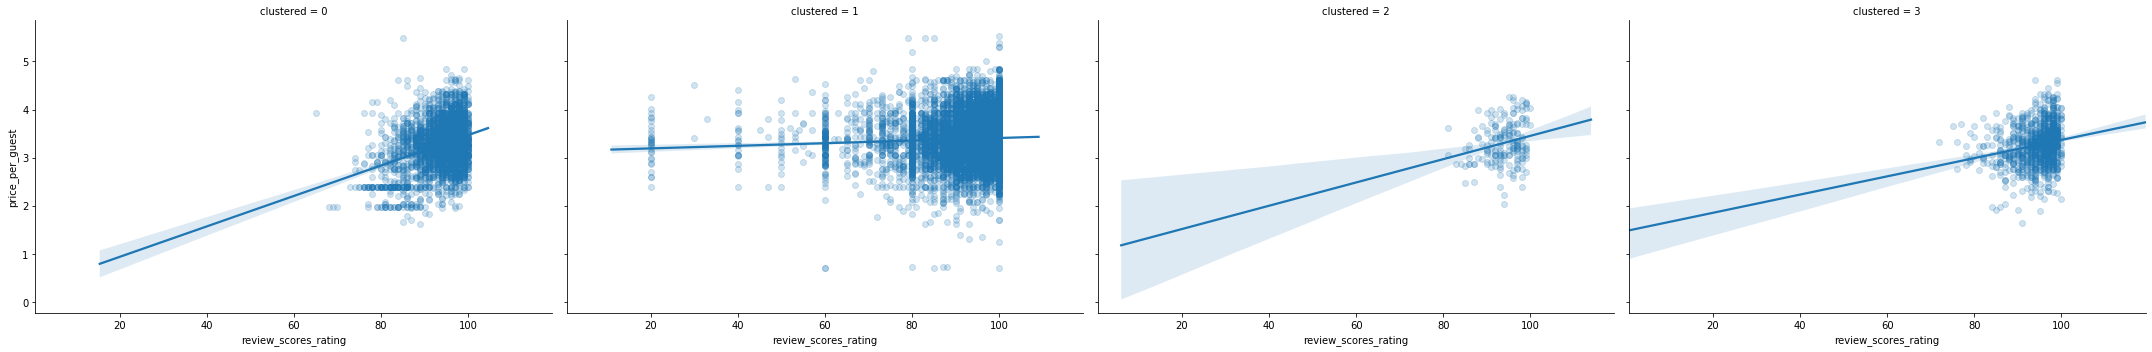

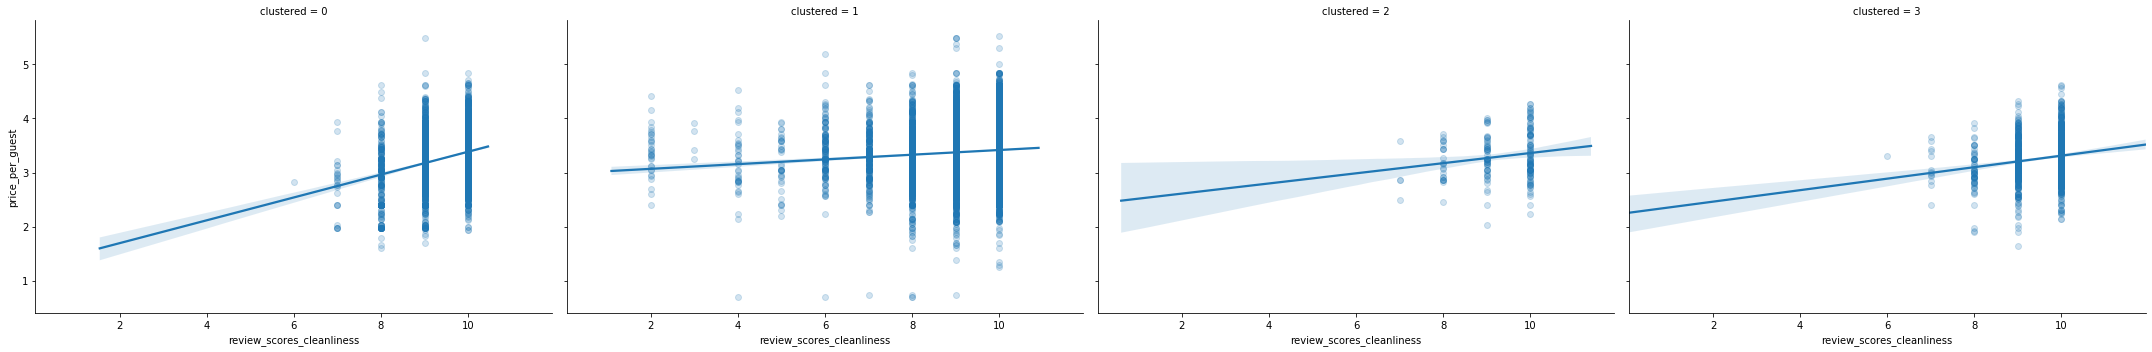

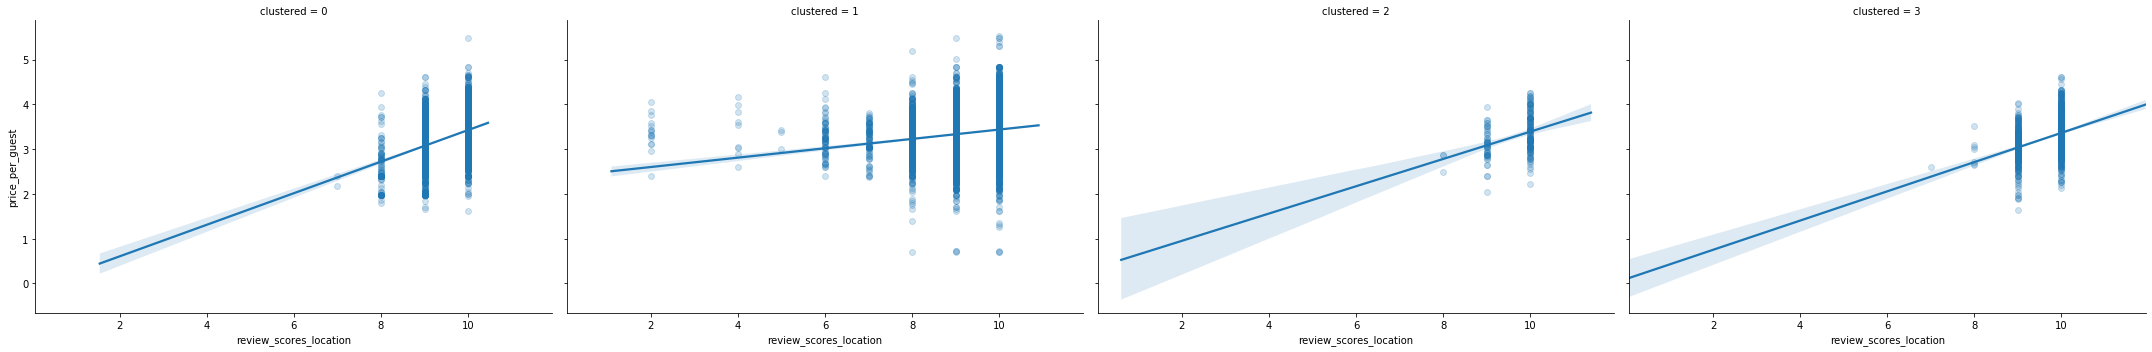

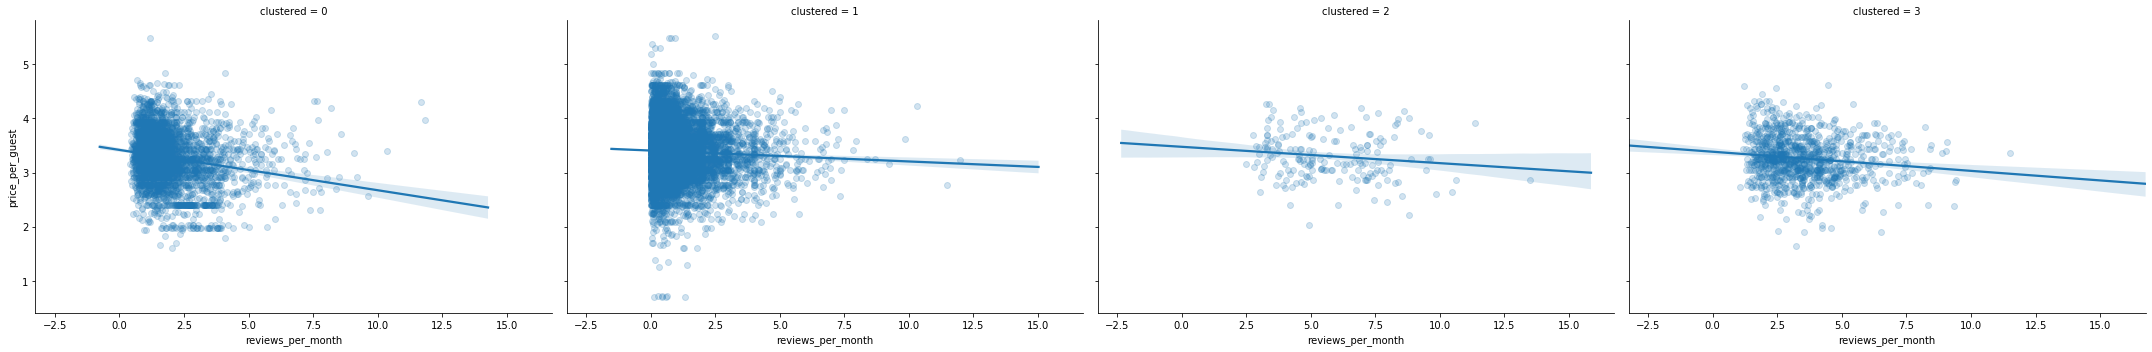

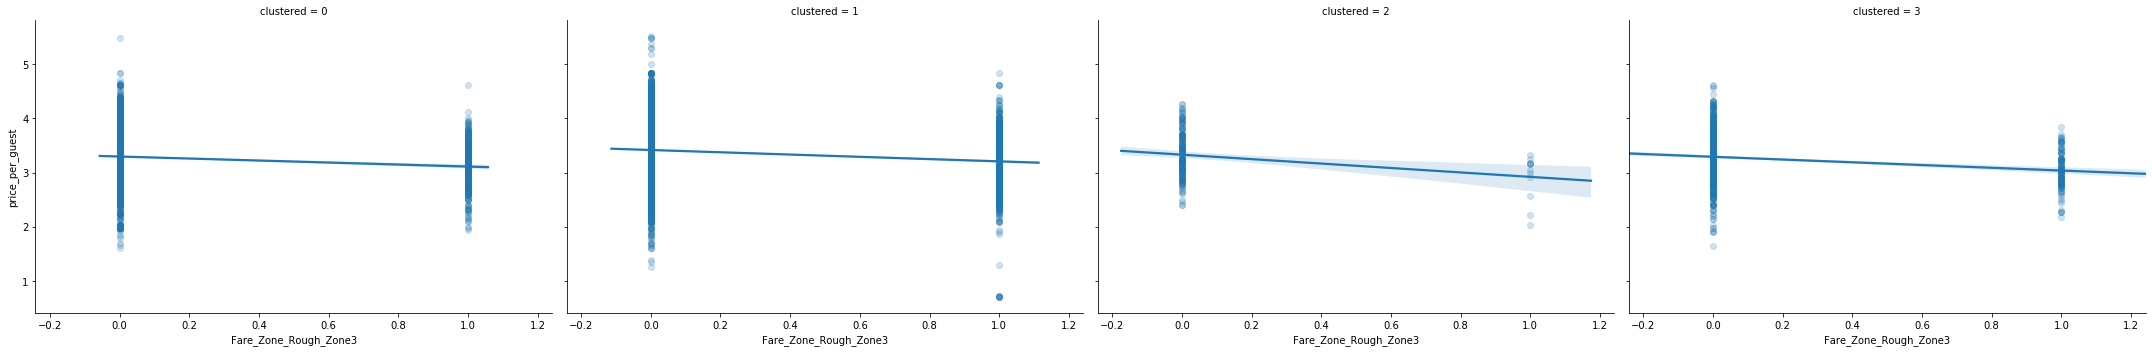

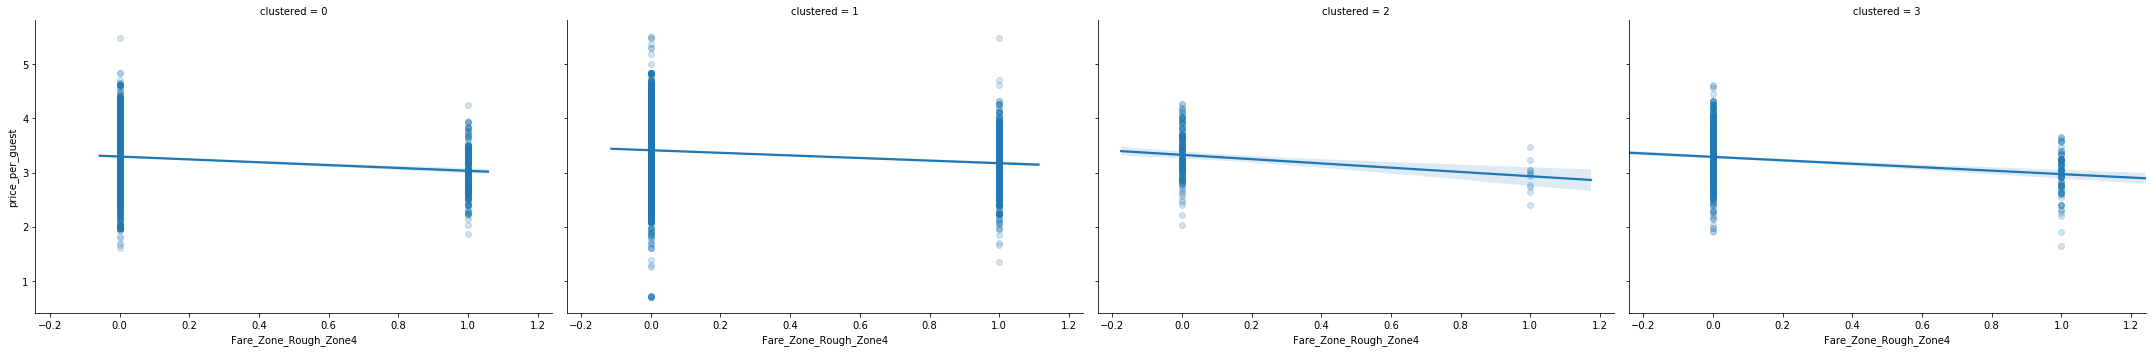

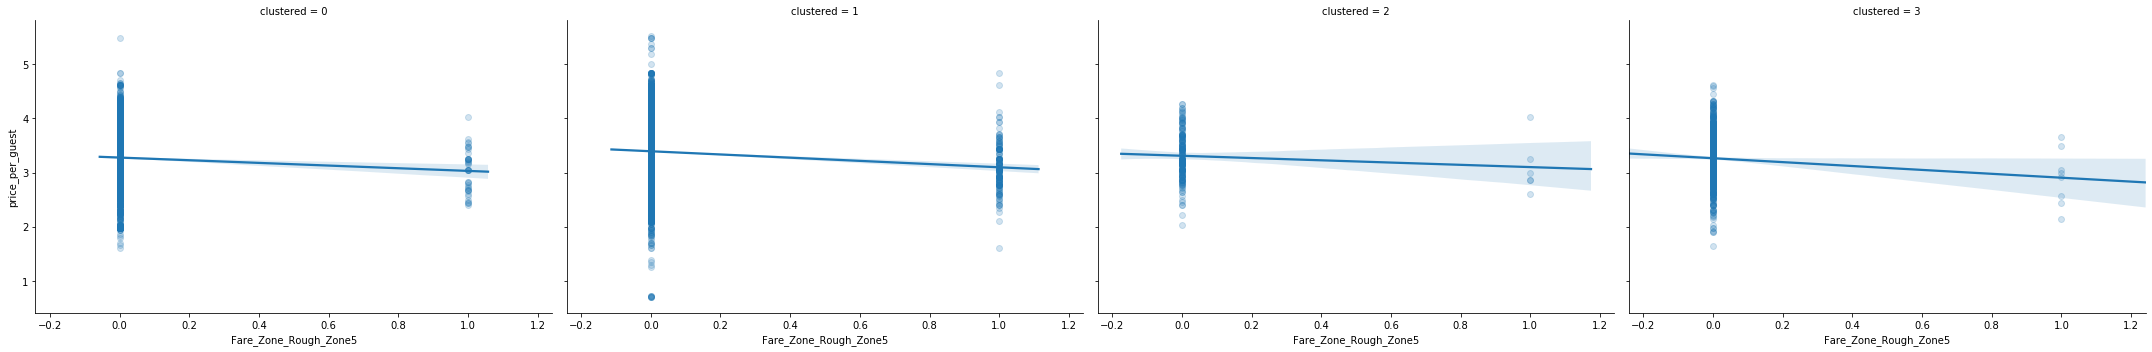

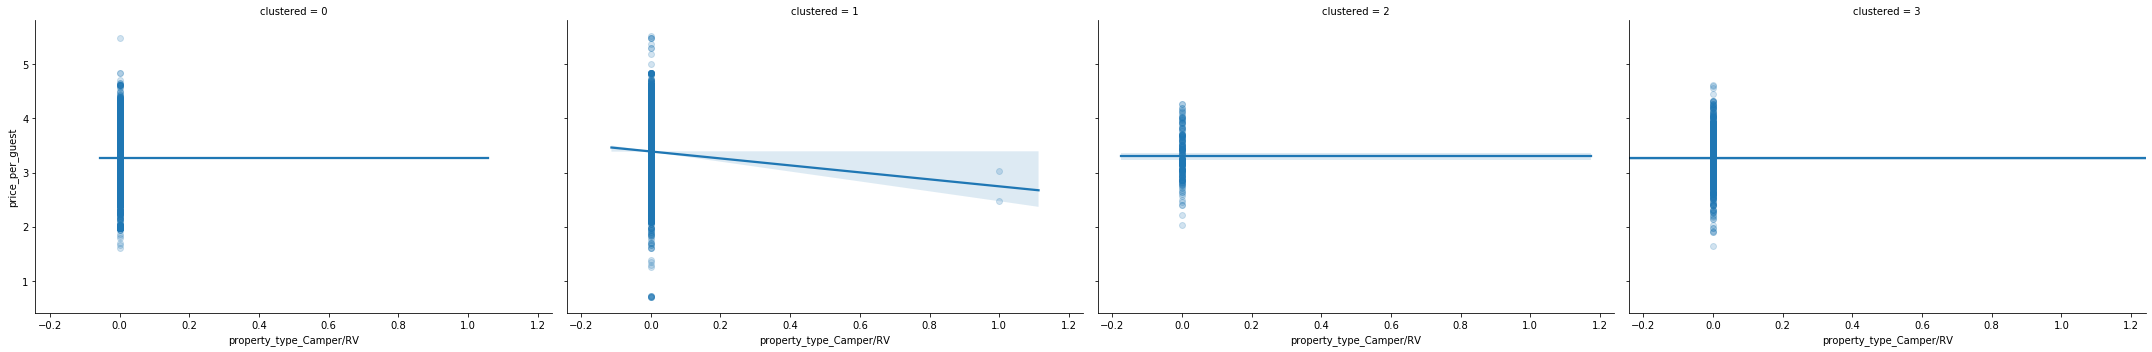

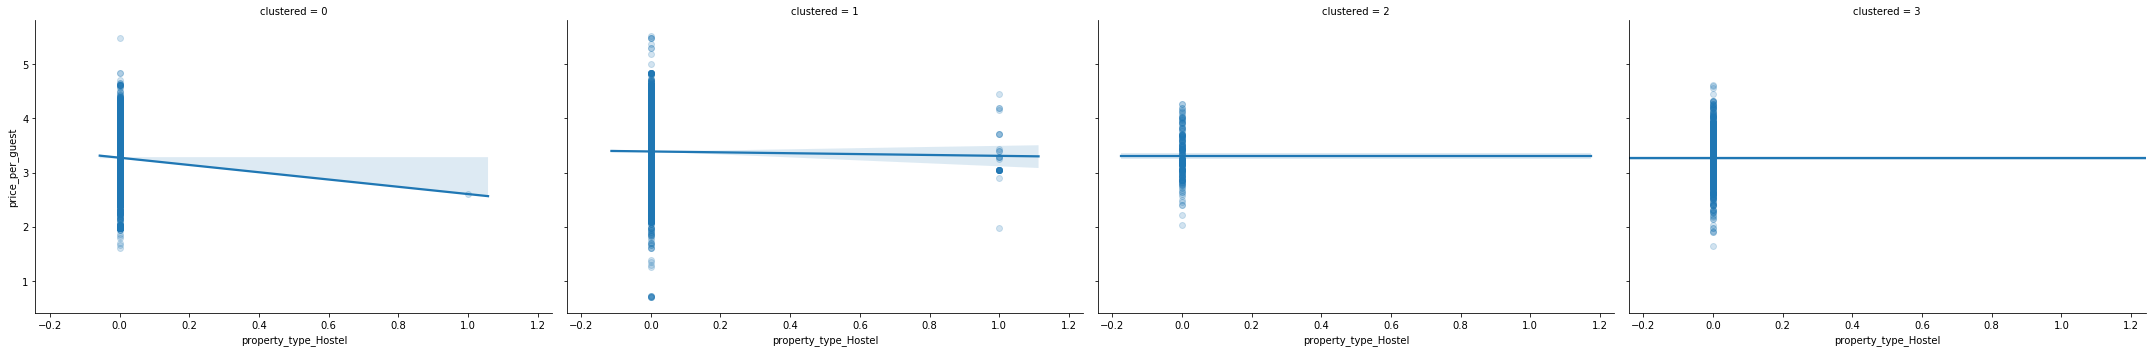

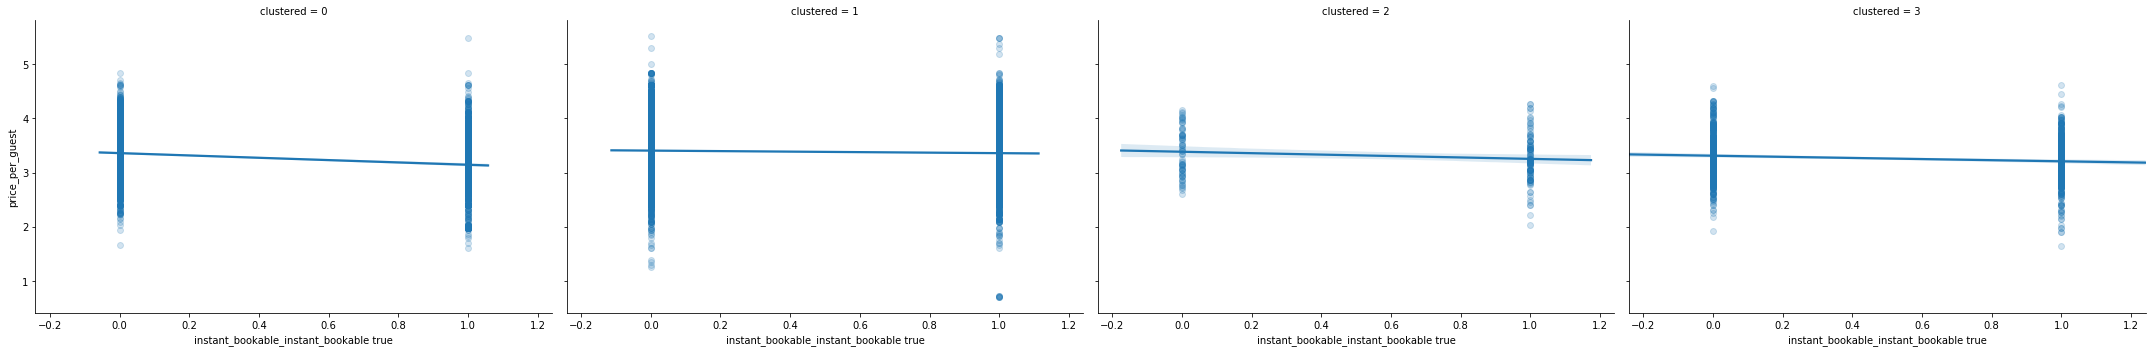

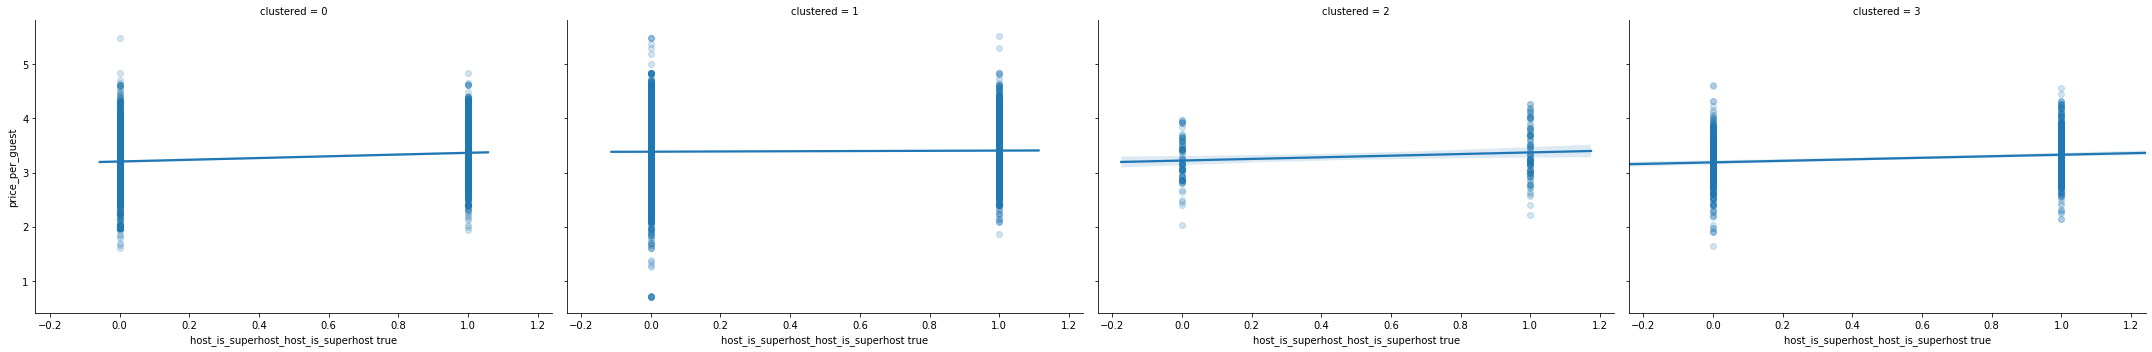

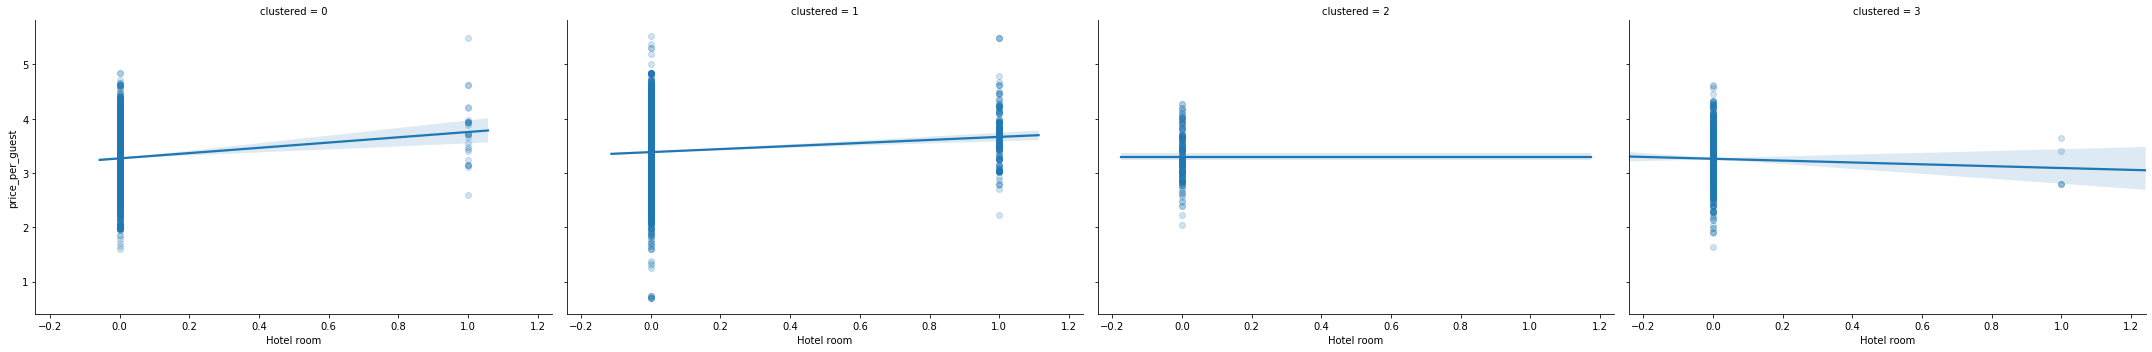

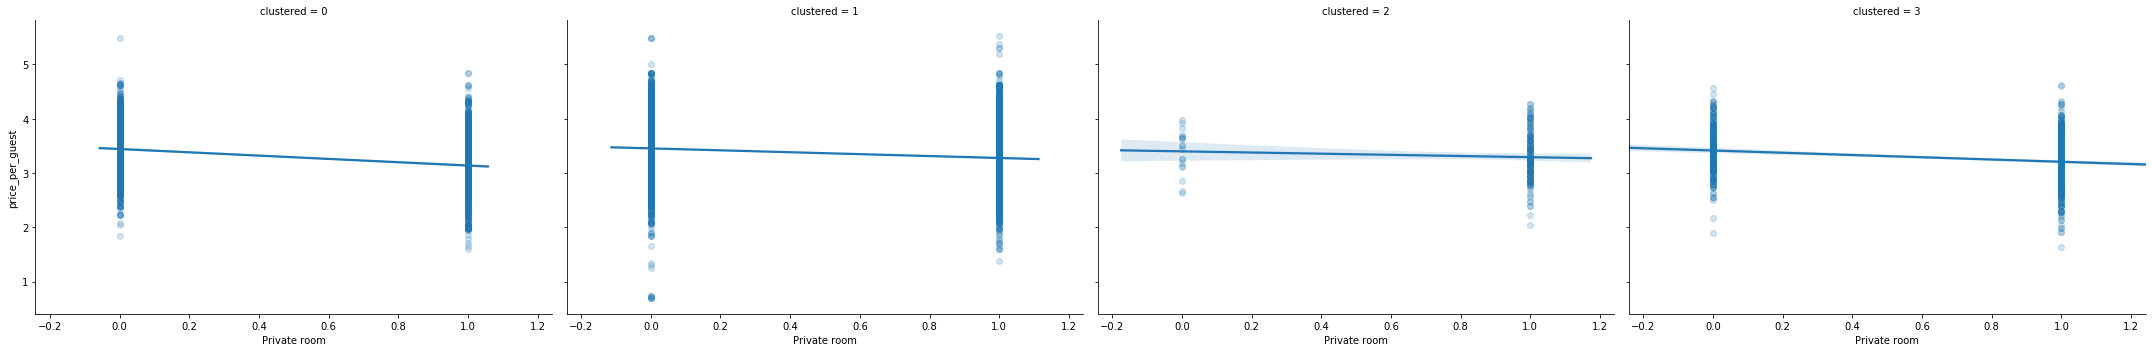

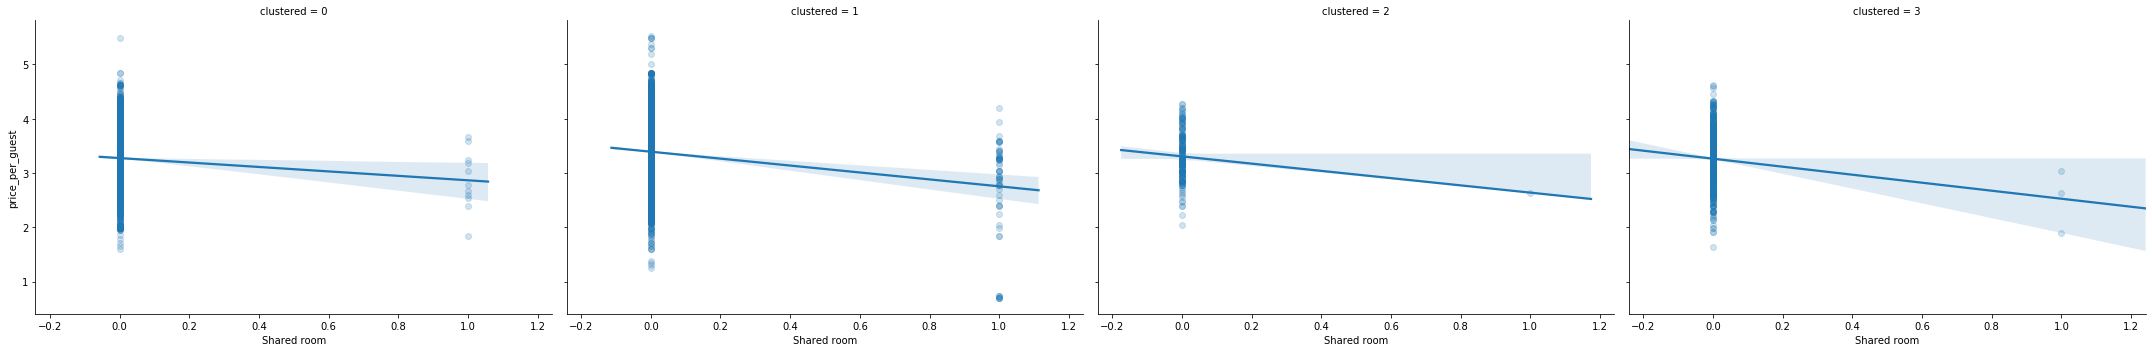

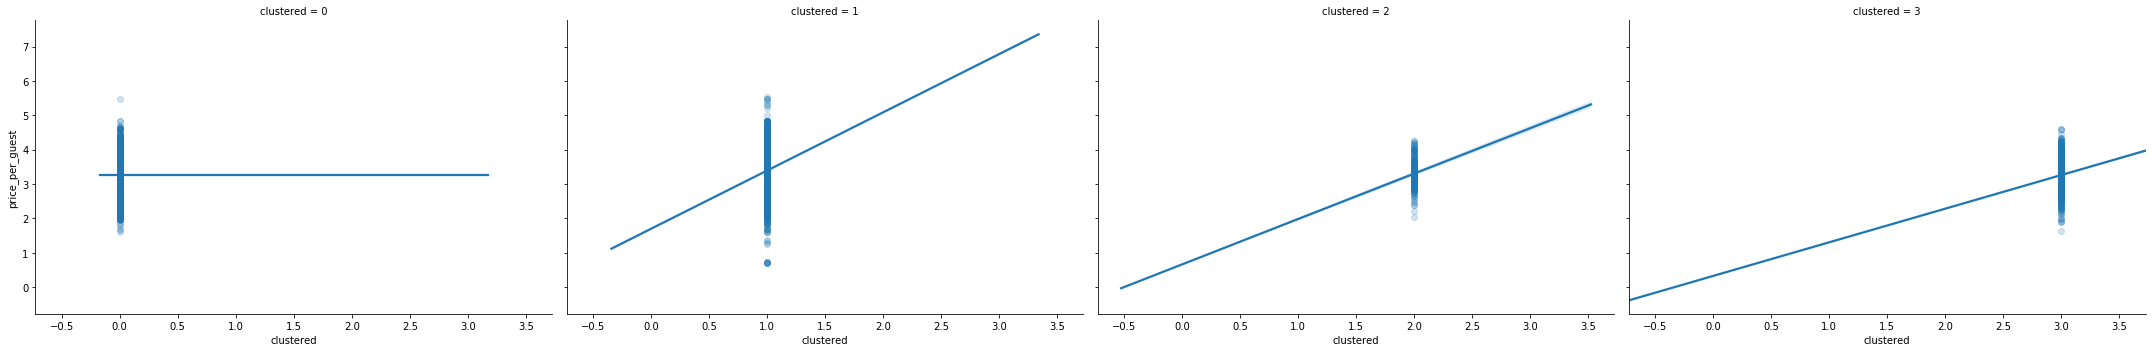

In [233]:
for item in X.columns:
    sns.lmplot(x=item, y="price_per_guest", data=data_listings, aspect=1.5, scatter_kws={'alpha':0.2},col='clustered');

In [235]:
#try gradient boosting and ada boosting

In [239]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


In [248]:
params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train,Y_train)
mse = mean_squared_error(Y_test, clf.predict(X_test))

In [249]:
print("MSE: %.4f" % mse)

MSE: 0.1427


In [250]:
print ('R2: ', r2_score(Y_test,clf.predict(X_test)))

R2:  0.33009453579975


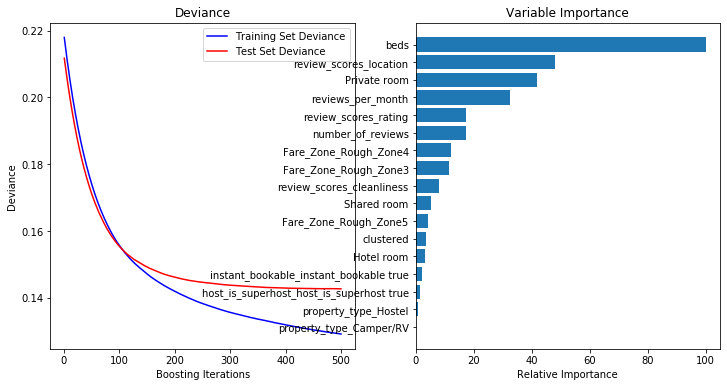

In [254]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(Y_test, y_pred)

mpl.pyplot.figure(figsize=(12, 6))
mpl.pyplot.subplot(1, 2, 1)
mpl.pyplot.title('Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
mpl.pyplot.legend(loc='upper right')
mpl.pyplot.xlabel('Boosting Iterations')
mpl.pyplot.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
mpl.pyplot.subplot(1, 2, 2)
mpl.pyplot.barh(pos, feature_importance[sorted_idx], align='center')
mpl.pyplot.yticks(pos, X.columns[sorted_idx])
mpl.pyplot.xlabel('Relative Importance')
mpl.pyplot.title('Variable Importance')
mpl.pyplot.show()

In [ ]:
#commit to parameter tuning

In [268]:
#tune max_depth
r2_list=[]
mse_list=[]
parameter_tuning= list(range(1, 10))
for depth in parameter_tuning :
    params = {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':depth}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train,Y_train)
    mse_list.append(mean_squared_error(Y_test, clf.predict(X_test)))
    
    r2_list.append(r2_score(Y_test,clf.predict(X_test)))

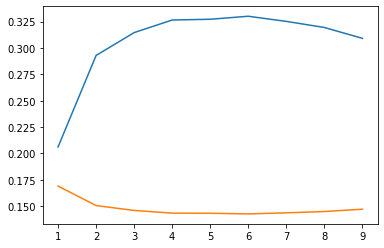

In [270]:
mpl.pyplot.plot(parameter_tuning,r2_list)
mpl.pyplot.plot(parameter_tuning,mse_list)

In [273]:
sorted(zip(r2_list, parameter_tuning))[-1]

(0.3301261868667934, 6)

In [ ]:
#6 max depth

In [280]:
r2_list=[]
mse_list=[]
parameter_tuning= list(range(1, len(X.columns)+1))
for depth in parameter_tuning:
    params = {'n_estimators': 500, 'max_features': depth, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':6}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train,Y_train)
    mse_list.append(mean_squared_error(Y_test, clf.predict(X_test)))
    
    r2_list.append(r2_score(Y_test,clf.predict(X_test)))

(0.33441400266989574, 7)

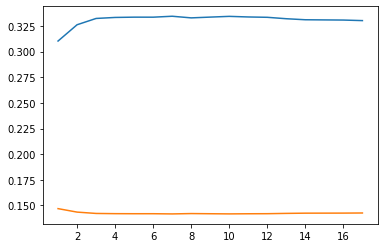

In [281]:
mpl.pyplot.plot(parameter_tuning,r2_list)
mpl.pyplot.plot(parameter_tuning,mse_list)
sorted(zip(r2_list, parameter_tuning))[-1]

In [ ]:
#let's keep it at 17 features and tune learning rate


In [234]:
#bring in sparse matrix

In [282]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
import nltk

%matplotlib inline

In [283]:
text_fields=['amenities','summary','space', 'description', 'experiences_offered', 'neighborhood_overview']
for field in text_fields:
    data_listings[field]= data_listings[field].str.replace(r'[^\x00-\x7F]+', '')

In [284]:
data_listings['text_all']=data_listings['name']+" "+data_listings['summary']+' '+data_listings['amenities']+" "+data_listings['neighborhood_overview']

In [286]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Camper/RV',
       'property_type_Hostel','instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true','Hotel room', 'Private room',
       'Shared room','clustered','text_all']]
y=data_listings.price_per_guest
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [289]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('or')
stop.append('in')
stop.append('to')
stop.append('km')
stop.append('the')
stop.append('in')
stop.append('of')


stemmer = PorterStemmer()
lemma= WordNetLemmatizer()
# Stem each word.
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (lemma.lemmatize(w) for w in analyzer(doc))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [291]:
tfid_vect=TfidfVectorizer(lowercase=True,stop_words=stop,analyzer=stemmed_words,min_df=3,ngram_range=(1,3))
rf_reg=RandomForestRegressor()
X_train_dtm = tfid_vect.fit_transform(X_train.text_all)
print(('Features: ', X_train_dtm.shape[1]))
X_test_dtm = tfid_vect.transform(X_test.text_all)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_dtm, y_train)
y_pred_class = rf_reg.predict(X_test_dtm)
print(('Accuracy: ', r2_score(y_test, y_pred_class)))
#(tfid_vect.get_feature_names())

('Features: ', 9113)
('Accuracy: ', 0.35048580494137493)


In [292]:
feature_importance =pd.DataFrame({'feature':tfid_vect.get_feature_names(), 'importance':rf_reg.feature_importances_}).sort_values(by='importance',ascending=False)

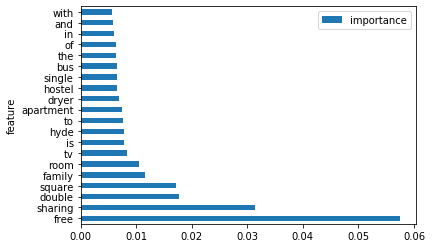

In [293]:
feature_importance[:20].plot('feature','importance',kind='barh')

In [299]:
pd.DataFrame(tfid_vect.fit_transform(X_test).toarray(), columns=tfid_vect.get_feature_names())

,room
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [303]:
import scipy as sp
extra =sp.sparse.csr_matrix(X_train.drop('text_all',axis=1)).astype('float')
extra.shape

(12105, 17)

In [304]:
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

(12105, 9130)

In [306]:
extra = sp.sparse.csr_matrix(X_test.drop('text_all', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(4036, 9130)

In [307]:
#repeat with gradient boosting regression
clf = GradientBoostingRegressor(**params)


In [310]:
params = {'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':6}


In [312]:
clf.fit(X_train_dtm_extra,y_train)
print(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
print(r2_score(y_test,clf.predict(X_test_dtm_extra)))

0.18001721975003107
0.19016583064426706


In [314]:
#depth
r2_list=[]
mse_list=[]
parameter_tuning= list(range(1, 10))
for param in parameter_tuning:
    params = {'n_estimators': 500, 'max_features': 9130, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':param}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train_dtm_extra,y_train)
    mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
    r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))

(0.46672743309566866, 9)

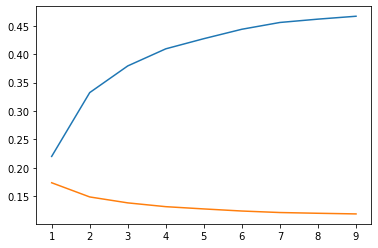

In [315]:
mpl.pyplot.plot(parameter_tuning,r2_list)
mpl.pyplot.plot(parameter_tuning,mse_list)
sorted(zip(r2_list, parameter_tuning))[-1]


In [319]:
#depth =9, max features
r2_list=[]
mse_list=[]
parameter_tuning= list(range(1, 9131))
for param in parameter_tuning:
    params = {'max_features': 9130, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':param}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train_dtm_extra,y_train)
    mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
    r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))

KeyboardInterrupt: 

(0.34132541651331105, 12)

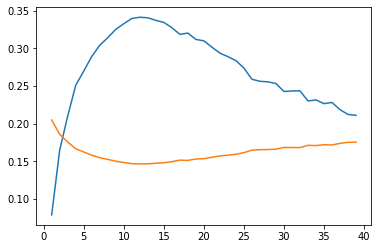

In [327]:
len(r2_list)
len(parameter_tuning[:39])
mpl.pyplot.plot(parameter_tuning[:39],r2_list)
mpl.pyplot.plot(parameter_tuning[:39],mse_list)
sorted(zip(r2_list, parameter_tuning[:39]))[-1]


In [317]:
pd.DataFrame(tfid_vect.fit_transform(X_test).toarray(), columns=tfid_vect.get_feature_names()).max(axis=0).sort_values(ascending=False)[:20]

room    1.0
dtype: float64

In [328]:
#depth =9, max features
r2_list=[]
mse_list=[]
parameter_tuning= list(range(1, 9131))
for param in parameter_tuning:
    params = {'max_features': 9131, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':9}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train_dtm_extra,y_train)
    mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
    r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))

KeyboardInterrupt: 

(0.265047349470669, 543)

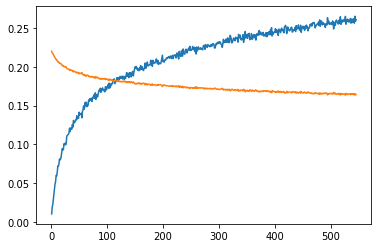

In [330]:
len(r2_list)
len(parameter_tuning[:545])
mpl.pyplot.plot(parameter_tuning[:545],r2_list)
mpl.pyplot.plot(parameter_tuning[:545],mse_list)
sorted(zip(r2_list, parameter_tuning[:545]))[-1]

In [342]:
r2_score(y_test,clf.predict(X_test_dtm_extra))

0.32519976444061693

In [381]:
#depth =9, max features
r2_list=[]
mse_list=[]
parameter_tuning= list(range(7500, 9131,100))
for param in parameter_tuning:
    params = {'max_features': param, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':9}
    clf = GradientBoostingRegressor(**params)

    clf.fit(X_train_dtm_extra,y_train)
    mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
    r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))

(0.32878505911283584, 7900)

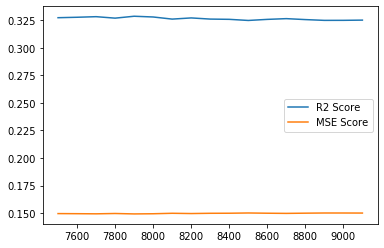

In [385]:
len(r2_list)
len(parameter_tuning[:545])
mpl.pyplot.plot(parameter_tuning[:545],r2_list,label="R2 Score");
mpl.pyplot.plot(parameter_tuning[:545],mse_list,label="MSE Score");
mpl.pyplot.legend();
sorted(zip(r2_list, parameter_tuning[:545]))[-1]


In [367]:
r2_score(y_test,clf.predict(X_test_dtm_extra))

0.3278027497723598

In [387]:
# Plot training deviance
import timeit
params = {'max_features': 7900, 'max_depth': 12, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls','n_estimators':500}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train_dtm_extra,y_train)
mse = mean_squared_error(y_test, clf.predict(X_test_dtm_extra))
print(mse)
print(r2_score(y_test,clf.predict(X_test_dtm_extra)))
# compute test set deviance
timeit

0.11723663947810958
0.4725935847601267


<module 'timeit' from 'C:\\Users\\isimr\\Anaconda3\\lib\\timeit.py'>

Text(0, 0.5, 'Deviance')

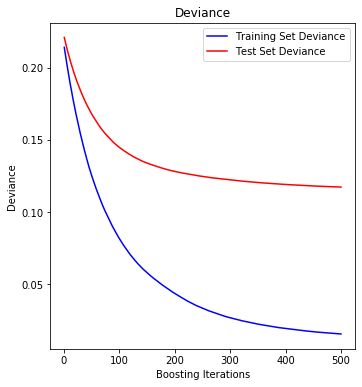

In [388]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test_dtm_extra)):
    test_score[i] = clf.loss_(y_test, y_pred)

mpl.pyplot.figure(figsize=(12, 6))
mpl.pyplot.subplot(1, 2, 1)
mpl.pyplot.title('Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
mpl.pyplot.legend(loc='upper right')
mpl.pyplot.xlabel('Boosting Iterations')
mpl.pyplot.ylabel('Deviance')



In [434]:
import requests
import urllib
import re
from bs4 import BeautifulSoup
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
url_ex='https://www.airbnb.co.uk/rooms/40882994?previous_page_section_name=3000&check_in=2020-04-29&check_out=2020-04-30&adults=1&children=0&infants=0'
example1= requests.get(url_ex)
soup =BeautifulSoup(example1.content,'html.parser')
name=(soup.find(id='summary').find('span',class_= '_18hrqvin')).text
listing_info = (soup.find_all(class_='_36rlri',style="margin-right:24px"))
guests=int(listing_info[0].text.split(" guests")[0])
property_type=listing_info[1].text.split(" beds")[0]
beds_no = int(listing_info[2].text.split(" bed")[0])
#superhost - default is 1
summary_listing=soup.find(id='details').find('span',class_= '_czm8crp').text
review_score_overall=float(soup.find(id='reviews').find('div',class_= '_1iv05u9z').text[:4])
review_score_loc=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[0].text)
review_score_clean=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[4].text)
#zone_dummy=mapping.get('Barnet')
#neighbourhood_ov=str(input())
review_no= soup.find(id='reviews').find('span',class_= '_krjbj').text[:4]



In [435]:
selector=widgets.SelectMultiple(
    options=['First aid kit','Fire extinguisher','Wifi', 'Dryer', 'Smoke Detector','Essentials','Heating','Iron','TV','Washing Machine','Kitchen','Hair dryer','Hangers','Carbon monoxide alarm','Air conditioning','Private entrance','shampoo'],
    value=['Wifi'],
    rows=15,
    description='Fruits',
    disabled=False
)
display(selector)

SelectMultiple(description='Fruits', index=(2,), options=('First aid kit', 'Fire extinguisher', 'Wifi', 'Dryer…

In [436]:
amenities= set()
amenities.add(selector.value)
print("Name: "+name)
print("Guests: "+str(guests))
print("Property Type: "+ str(property_type))
print("Beds No: " + str(beds_no))
print(summary_listing[:150])
print(review_score_overall)
print(review_score_loc)
print(review_score_clean)
print(amenities)

Name: West Kensington Hotel (double room, ensuite)
Guests: 2
Property Type: 1 bedroom
Beds No: 1
We are a family owned hotel located in a Victorian townhouse in a pretty street West Kensington, London. We have a private walled garden and offer a r
4.4
5.0
4.5
{('First aid kit', 'Fire extinguisher', 'Essentials', 'Hangers', 'Carbon monoxide alarm')}


In [437]:
fieldsa={'beds', 'number_of_reviews','review_scores_rating','review_scores_cleanliness','review_scores_location',
"require_guest_profile_picture_require_guest_profile_picture true", 'instant_bookable_instant_bookable true','host_is_superhost_host_is_superhost true', 'host_has_profile_pic_host_has_profile_pic true',
'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
        'property_type_Serviced apartment', 'property_type_Tiny house', 'property_type_Treehouse',
       'property_type_Villa',
 'room_type_Private room',
       'room_type_Shared room'}

In [450]:
new_input={}
for col in fieldsa:
    new_input[col]=np.nan

In [451]:
def update_new_input(new_input):
    new_input['beds']=beds_no
    new_input['number_of_reviews']=review_no
    new_input['review_scores_rating']=review_score_overall  
    new_input['review_scores_cleanliness']:review_score_clean
    new_input["require_guest_profile_picture_require_guest_profile_picture true"]=1
    new_input['instant_bookable_instant_bookable true']=1
    new_input['host_is_superhost_host_is_superhost true']=0
    new_input['host_has_profile_pic_host_has_profile_pic true']=1,
    new_input['name']=name
    new_input['amenities']=amenities
    new_input['summary']=summary_listing
    new_input['review_scores_location']=review_score_loc
    

In [465]:
#Update as needed using these
property_type=listing_info[1].text.split(" beds")[0]
zone_dummy=mapping.get(input('Type borough here '))
neighbourhood_ov=str(input('Type neighbourhood overview here '))
new_input['neighborhood_overview']=neighbourhood_ov    
text_string= name+ " " + summary_listing +" " + str(amenities) + " "+ neighbourhood_ov
new_input['text_all']=text_string;
zone_dummy

Type borough here ksks
Type neighbourhood overview here Amy’s place is located in Greater London, England, United Kingdom. West Kensington is a delightful area with plenty of wonderful pubs, and resturants. A great choice of different cuisines. Kensington Olympia Exhibition centre is a 5 minute walk away and West Kensington Tube Station affords easy access to all areas of London.


In [466]:
X_test=X_test.append(new_input,ignore_index=True);

In [467]:
X_test_trial=X_test.loc[X_test.shape[0]-1].to_frame().T

In [468]:
X_test_dtm_trialed = tfid_vect.transform(X_test_trial.text_all)


In [475]:
pd.DataFrame(tfid_vect.transform(X_test_trial).toarray(), columns=tfid_vect.get_feature_names()).max(axis=0).sort_values(ascending=False)[:20]

true    1.0
room    1.0
dtype: float64

In [474]:
X_test_dtm_trialed
#X_test_trial.text_all.values

<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [472]:
trial_xtra=sp.sparse.csr_matrix(X_test_trial.drop('text_all',axis=1)).astype(np.float)
trial_xtra.shape

TypeError: no supported conversion for types: (dtype('O'),)

In [448]:
y_pred_class_trialed = rf_reg.predict(X_test_dtm_trialed)
#print(('Accuracy: ', r2_score(y_test, y_pred_class)))


ValueError: Number of features of the model must match the input. Model n_features is 9113 and input n_features is 1 